In [1]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%%capture
!pip install xgboost

In [3]:
import os
import matplotlib.pyplot as plt 
import PIL
from PIL import Image
import glob

import torch 
import torch.nn as nn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tqdm

## Invetsigate Data (EDA)

In [4]:
dataset_path = '/kaggle/input/human-action-detection-artificial-intelligence/emirhan_human_dataset/datasets/human_data'
labels_path = '/kaggle/input/human-action-detection-artificial-intelligence/emirhan_human_dataset/datasets/data.txt'

#### Read labels

In [5]:
data_label = open(labels_path, 'r')
with open(labels_path) as f:
    lines = f.readlines()
    labels = [line.split('\n')[0].lower() for line in lines]

#### Collect train and test images path

In [6]:
train_img_path = {}
test_img_path = {}

for label in labels:
    train_img_path[label] = glob.glob(os.path.join(dataset_path, 'train_data', label, '*.jpg'))
    test_img_path[label] = glob.glob(os.path.join(dataset_path, 'test_data', label, '*.jpg'))

In [7]:
# I want to ensure that we have the same training and testing labels
print('Train:')
for label in labels:
    print('{}: {}'.format(label, len(train_img_path[label])))
    
print('Test:')
for label in labels:
    print('{}: {}'.format(label, len(test_img_path[label])))

Train:
calling: 1000
clapping: 1000
cycling: 1000
dancing: 1000
drinking: 1000
eating: 1000
fighting: 1000
hugging: 1000
laughing: 1000
listenning to music: 0
running: 1000
sitting: 1000
sleeping: 1000
texting: 1000
using laptop: 0
Test:
calling: 200
clapping: 200
cycling: 200
dancing: 200
drinking: 200
eating: 200
fighting: 200
hugging: 200
laughing: 200
listenning to music: 0
running: 200
sitting: 200
sleeping: 200
texting: 200
using laptop: 0


In [8]:
# Yeah, it is a weird way to remove data 
del train_img_path['listenning to music'], train_img_path['using laptop'], train_img_path['calling'], train_img_path['clapping'], train_img_path['dancing'], train_img_path['drinking']
del test_img_path['listenning to music'], test_img_path['using laptop'], test_img_path['calling'], test_img_path['clapping'], test_img_path['dancing'], test_img_path['drinking']
# del train_img_path['eating'], train_img_path['sitting'], train_img_path['sleeping'], train_img_path['texting']

In [9]:
# labels selected 
labels = list(train_img_path.keys())
print(len(labels))

9


## Create Transformer for Images

In [10]:
import torchvision
from torchvision import transforms

#### Image augmentation

In [11]:
# this transform makes training more robust
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.ColorJitter(contrast=.5, hue=.3),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                         std=(0.229, 0.224, 0.225)),
                                   ])

# this is the normal transform to validate and test the model
transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                     std=(0.229, 0.224, 0.225)),
                               ])

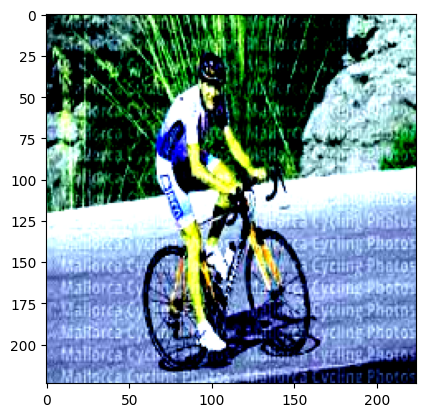

In [12]:
# sample image from training dataset
im = Image.open(train_img_path[labels[0]][1])
im_t = transform_train(im)
plt.imshow(im_t.permute(1, 2, 0))

## Create custom Dataset and Dataloader

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
# create data csv
train_dict = {'path':[], 'class':[]}
for label in train_img_path:
    train_dict['path'] += train_img_path[label]
    train_dict['class'] += [label] * len(train_img_path[label])
    
train_df = pd.DataFrame(train_dict)

In [15]:
## create data csv
test_dict = {'path':[], 'class':[]}
for label in train_img_path:
    test_dict['path'] += test_img_path[label]
    test_dict['class'] += [label] * len(test_img_path[label])
    
test_df = pd.DataFrame(test_dict)

In [16]:
labels_idx = list(train_img_path.keys())
train_df['label'] = train_df['class'].apply(lambda x: labels_idx.index(x))
test_df['label'] = test_df['class'].apply(lambda x: labels_idx.index(x))

In [17]:
class human_action_dataset(Dataset):
    def __init__(self, csv, transform=None):
        super().__init__()
        self.df = csv
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'label']
        label_class = self.df.loc[idx, 'class']
        
        img = Image.open(path)
        if self.transform:
            sample = self.transform(img)
            
        return sample, label, label_class

In [18]:
train_dataset = human_action_dataset(train_df, transform_train)
test_dataset = human_action_dataset(test_df, transform_test)

In [19]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              drop_last=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size, 
                             shuffle=True, 
                             drop_last=True)

## CNN Model architecture - Transfer learning

In [20]:
import torch.nn as nn

In [21]:
'''
I am using a pretrained resnet18 model.
I am freezing most of the layers (no updates of weight and biases) and adjsuting last layer based on number of classes (Transfer learning)
'''
class custom_res18(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        
        self.cnn = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        for name, param in self.cnn.named_parameters():
            if 'layer4' not in name:
                param.requires_grad = False
            
        fc = nn.Linear(self.cnn.fc.in_features, num_labels)
        self.cnn.fc = fc
    
    def forward(self, x):
        return self.cnn(x)

## Train-Test CNN model

In [22]:
device = 'cuda'
model = custom_res18(len(labels)).to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s] 


In [23]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training function

In [24]:
# create function to train for a single epoch
def train_one_epoch(epoch_idx, tb_writer, device):
    running_loss = 0.
    last_loss = 0
    for i, (batch, true_labels, cc) in enumerate(train_dataloader):
        # zero gradient for each batch
        optimizer.zero_grad()
        
        # batch prediction
        predictions = model(batch.to(device))
        
        # compute loss and gradients
        loss = loss_fn(predictions, true_labels.to(device))
        loss.backward()
        
        # adjust learning weights
        optimizer.step()
        
        # Gather data and report every 100 batches
        running_loss += loss.item()
    
    last_loss = running_loss / len(train_dataloader) # loss per batch
#     print('  batch {} loss: {}'.format(i + 1, last_loss))
    tb_x = epoch_idx * len(train_dataloader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.
            
#     print('LR: {}'.format(optimizer.param_groups[0]['lr']))
    
    return last_loss

In [25]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Training CNN model

In [26]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.
train_losses = []
val_losses = []


for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, device)
    train_losses.append(avg_loss)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (vdata, vlabels, cc) in enumerate(test_dataloader):
#             vinputs, vlabels, _ = vdata
            vinputs = vdata.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_losses.append(avg_vloss.cpu())
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state (validation loss)
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.7178867880787169 valid 0.6131418347358704
EPOCH 2:
LOSS train 0.4126943954399654 valid 0.573076069355011
EPOCH 3:
LOSS train 0.28652903203453334 valid 0.6407293081283569
EPOCH 4:
LOSS train 0.20666988992265292 valid 0.6469296813011169
EPOCH 5:
LOSS train 0.16161554689918245 valid 0.6871631741523743
EPOCH 6:
LOSS train 0.11497500091791153 valid 0.7716769576072693
EPOCH 7:
LOSS train 0.09858735709318094 valid 0.6680213212966919
EPOCH 8:
LOSS train 0.08079461178609303 valid 0.5973183512687683
EPOCH 9:
LOSS train 0.07118350528180599 valid 0.6565827131271362
EPOCH 10:
LOSS train 0.06833165817494903 valid 0.6981543302536011


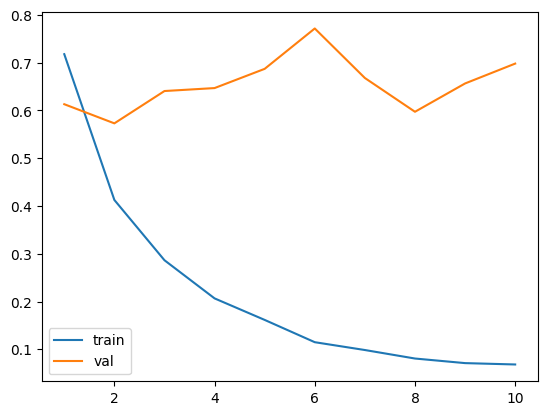

In [27]:
epoch=EPOCHS-1 # number of epochs - 1
plt.plot(np.arange(1, epoch+2), np.array(train_losses), label='train')
plt.plot(np.arange(1, epoch+2), np.array(val_losses), label='val')
plt.legend()

In [28]:
# selecting best performing epoch and loading model weights
print('Path to best epoch: {}'.format(model_path))

Path to best epoch: model_20240727_191226_1


In [29]:
device = 'cuda'
model = custom_res18(len(labels)).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print('Done! Model is loaded...: {}'.format(model_path))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done! Model is loaded...: model_20240727_191226_1


#### Evaluate model (CNN only)

In [30]:
classes_ident = nn.Softmax(1)
correct = 0

for i, (vdata, vlabels, cc) in enumerate(test_dataloader):
    vout = model(vdata.to(device))
    pred_labels = classes_ident(vout).argmax(dim=1)
    correct += torch.sum(pred_labels.cpu() == vlabels)

In [31]:
print('Accuracy: {}'.format(correct/len(test_dataset)))

Accuracy: 0.8094444274902344


Here using the CNN alone we achieved 82% accuracy for the 5 classes selected

#### Extract features from CNN

In [32]:
from torchvision.models.feature_extraction import create_feature_extractor
return_nodes = {'cnn.avgpool':'avgpool'}
body = create_feature_extractor(model.to('cpu'), return_nodes=return_nodes) # feature extraction layer

#### Feature extraction using CNN model

In [33]:
train_features_li = []
train_labels_li = []

for train_data, train_labels, _ in tqdm.tqdm(train_dataloader):
    features = torch.squeeze(body(train_data.to('cpu'))['avgpool'])
    train_features_li.append(features)
    train_labels_li.append(train_labels)

100%|██████████| 70/70 [06:38<00:00,  5.69s/it]


In [34]:
train_features = torch.cat(train_features_li)
train_labels = torch.cat(train_labels_li)

In [35]:
test_features_li = []
test_labels_li = []

for test_data, test_labels, _ in tqdm.tqdm(test_dataloader):
    features = torch.squeeze(body(test_data.to('cpu'))['avgpool'])
    test_features_li.append(features)
    test_labels_li.append(test_labels)

100%|██████████| 14/14 [01:10<00:00,  5.03s/it]


In [36]:
test_features = torch.cat(test_features_li)
test_labels = torch.cat(test_labels_li)

In [37]:
X_train = train_features.detach().cpu().numpy()
y_train = train_labels.detach().cpu().numpy()
X_test = test_features.detach().cpu().numpy()
y_test = test_labels.detach().cpu().numpy()

## Dimensionality reduction

In [38]:
from sklearn.decomposition import PCA

Total variance explained by 100 components: 0.9919523596763611
Total variance explained by 40 components: 0.9822115898132324


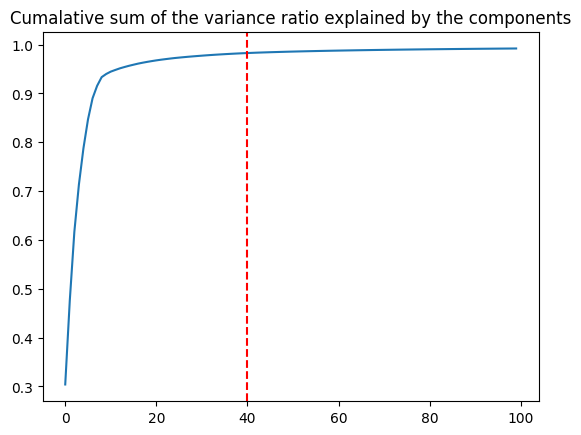

In [39]:
pca = PCA(n_components=100)
pca.fit(X_train)
print('Total variance explained by 100 components: {}'.format(np.sum(pca.explained_variance_ratio_)))

num_comps = 40

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=num_comps, color='red', ls='--')
plt.title('Cumalative sum of the variance ratio explained by the components')

pca = PCA(n_components=num_comps)
pca.fit(X_train)
print('Total variance explained by {} components: {}'.format(num_comps, np.sum(pca.explained_variance_ratio_)))

In [40]:
x_train = pca.transform(X_train)
x_test = pca.transform(X_test)

## Train and Test XGBoost model using the features from CNN

In [41]:
import xgboost as xgb

In [42]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [43]:
predicted_y = model.predict(x_test)

In [44]:
accuracy = np.sum(y_test == predicted_y)/y_test.shape[0]
print('Overall model accuracy: {}'.format(accuracy))

Overall model accuracy: 0.8270089285714286


## Final notes